In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install pillow
#!pip install opencv-python
#!pip install pyqt5 pyqtwebengine
#!pip install tensorflow
#!pip install scikit-learn

In [60]:
#Import bibliotek
import pandas as pd
from glob import glob
import random
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [3]:
# Załadowanie danych
file_path = 'data/HAM10000_metadata.csv'

df = pd.read_csv(file_path, sep=',')
df.head()

image_directory = 'D:/magisterka_new/CNN_HAM10000/data/HAM10000_images_part_1'


In [4]:
# Usunięcie niepotrzebnych kolumn
relevant_columns = ['lesion_id', 'image_id', 'dx', 'age','sex','localization']
df = df[relevant_columns]

In [5]:
df.head()

lesion_id      image_id   dx   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl  75.0  male          ear

In [6]:
# Sprawdzenie wartości null
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
age             57
sex              0
localization     0
dtype: int64

In [7]:
#Czyszczenie danych
df = df.dropna(subset=['age'])
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
age             0
sex             0
localization    0
dtype: int64

In [8]:
# Sprawdzenie duplikatów w kolumnie image_id
duplicates = df.duplicated(subset=['image_id'])
duplicates.sum()

0

In [9]:
# Sprawdzenie min wartości age
min_age = df['age'].min()
print(min_age)
# Sprawdzenie max wartości age
max_age = df['age'].max()
print(max_age)


0.0
85.0


In [10]:
sex_counts = df['sex'].value_counts()

# Usuwanie wierszy z unknown w zmiennej sex
df = df[df['sex'] != 'unknown']
# Usuwanie wierszy z unknown w zmiennej localization
df = df[df['localization'] != 'unknown']

In [11]:
# Tablica do przechowywania rozdzielczości
resolutions = []

# Sprawdzenie rozdzielczości wszystkich obrazów
for filename in os.listdir(image_directory):
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join(image_directory, filename))
        resolutions.append(img.size)

# Wyświetlenie unikalnych rozdzielczości w obrazach
unique_resolutions = set(resolutions)
print(f"Unikalne rozdzielczości: {unique_resolutions}")


Unikalne rozdzielczości: {(600, 450)}


In [12]:
# Zmienna do śledzenia, czy znaleziono pliki inne niż .jpg
no_jpg_found = False

# Wyświetlenie obrazów, które nie są w formacie .jpg
for filename in os.listdir(image_directory):
    if not filename.endswith(".jpg"):
        no_jpg_found = True  # Ustawienie flagi, jeśli znajdzie się plik inny niż .jpg
        img = Image.open(os.path.join(image_directory, filename))
        print(f"{filename}: {img.format}")

# Sprawdzenie zmiennej
if not no_jpg_found:
    print("Wszystkie pliki są w formacie .jpg")

Wszystkie pliki są w formacie .jpg


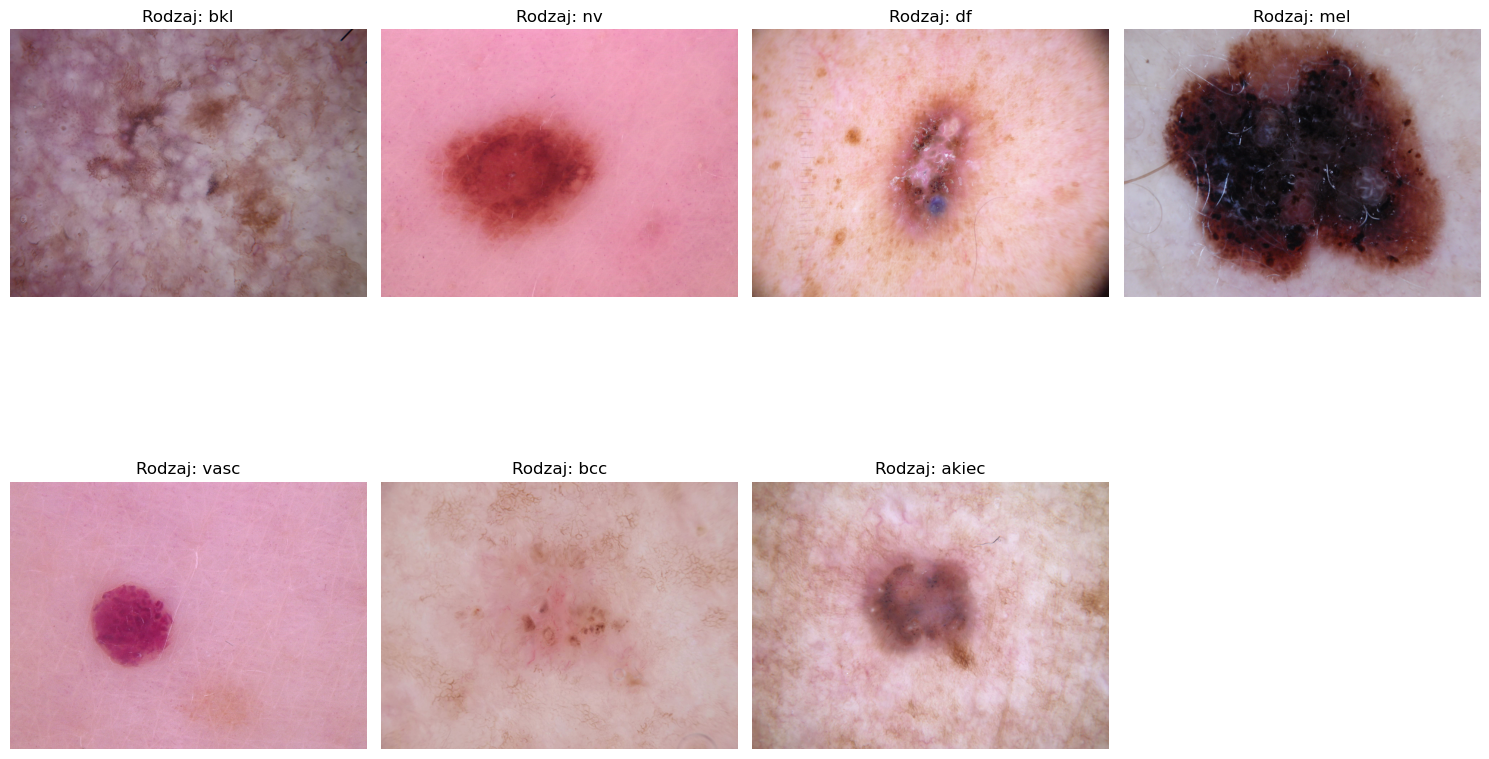

In [13]:
# Lista unikalnych etykiet dx
uni_dx = df['dx'].unique()

plt.figure(figsize=(15, 10))

for i, dx_val in enumerate(uni_dx):
    # Filtracja obrazów z bieżącą etykietą dx
    sample = df[df['dx'] == dx_val].sample(1).iloc[0]

    # Sprawdzenie ścieżki obrazu
    img_path = os.path.join(image_directory, sample['image_id'] + '.jpg')

    # Otwieranie obrazu
    img = Image.open(img_path)

    # Wyświetlenie obrazu
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Rodzaj: {sample['dx']}")
    plt.axis('off')

plt.tight_layout()
plt.show()


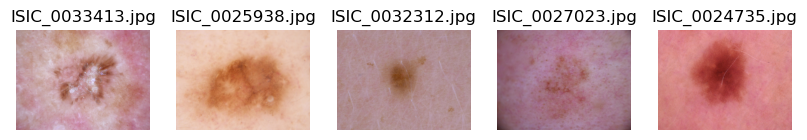

In [14]:
# Losowe wyświetlanie kilku obrazów
sample_images = random.sample(os.listdir(image_directory), 5)

plt.figure(figsize=(10, 10))

for i, filename in enumerate(sample_images):
    img = Image.open(os.path.join(image_directory, filename))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(filename)
    plt.axis('off')

plt.show()


In [15]:
#Sprawdzenie unikalności
hashes = {}
for filename in os.listdir(image_directory):
    img = Image.open(os.path.join(image_directory, filename))
    img_hash = hash(img.tobytes())

    if img_hash in hashes:
         print(f"Duplikat znaleziony: {filename} i {hashes[img_hash]}")
         img1 = Image.open(os.path.join(image_directory, filename))
         img2 = Image.open(os.path.join(image_directory, hashes[img_hash]))
         img1.show()
         img2.show()

    else:
        hashes[img_hash] = filename


Duplikat znaleziony: ISIC_0029861.jpg i ISIC_0024366.jpg
Duplikat znaleziony: ISIC_0029938.jpg i ISIC_0024777.jpg


In [16]:
#Sprawdzenie duplikatów
dupl = df[df['image_id'].isin(['ISIC_0024777', 'ISIC_0029938', 'ISIC_0029861','ISIC_0024366'])]
print(dupl)

        lesion_id      image_id  dx   age     sex localization
8260  HAM_0002300  ISIC_0029861  nv  35.0  female         back
8261  HAM_0002300  ISIC_0024366  nv  35.0  female         back
8303  HAM_0001895  ISIC_0029938  nv  25.0    male        chest
8304  HAM_0001895  ISIC_0024777  nv  25.0    male        chest


In [17]:
#Usunięcie zduplikowanych zdjęć
image_id_del1 = 'ISIC_0029861' 
image_id_del2 = 'ISIC_0029938'
df = df[df['image_id'] != image_id_del1]
df = df[df['image_id'] != image_id_del2]

# Sprawdzenie, czy wiersze zostały usunięte
print(df)


         lesion_id      image_id     dx   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl  75.0    male          ear
...            ...           ...    ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel  70.0  female         back

[9759 rows x 6 columns]


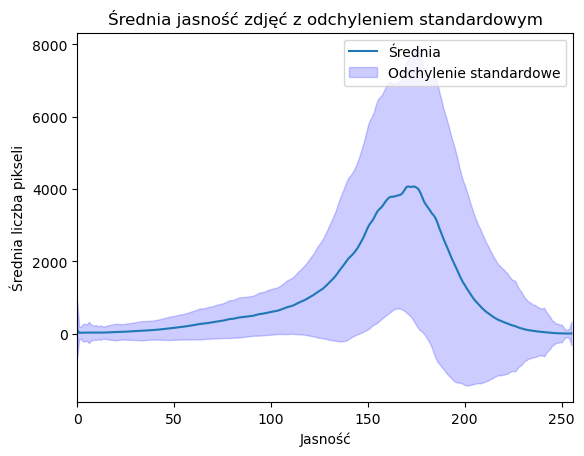

In [18]:
#Sprawdzenie jasności zdjęć
# Tablica do przechowywania histogramów
histograms = []

for filename in os.listdir(image_directory):
    if filename.endswith(".jpg"):
        # Ścieżka do obrazu
        image_path = os.path.join(image_directory, filename)

        # Odczytanie obrazu
        img = Image.open(image_path).convert('L')

        # Obliczenie histogramu i dodanie go do listy histogramów
        histogram = img.histogram()
        histograms.append(histogram[:256])

# Konwersja listy histogramów na tablicę NumPy
histograms = np.array(histograms)

# Obliczenie uśrednionego histogramu i odchylenia standardowego
average_histogram = np.mean(histograms, axis=0)
std_histogram = np.std(histograms, axis=0)

# Wyświetlenie histogramu z odchyleniem standardowym
plt.figure()
plt.title("Średnia jasność zdjęć z odchyleniem standardowym")
plt.xlabel("Jasność")
plt.ylabel("Średnia liczba pikseli")

# Rysowanie średniego histogramu
plt.plot(average_histogram, label="Średnia")

# Rysowanie odchylenia standardowego
plt.fill_between(range(256), average_histogram - std_histogram, average_histogram + std_histogram, color='b', alpha=0.2, label="Odchylenie standardowe")

plt.xlim([0, 256])
plt.legend()
plt.show()


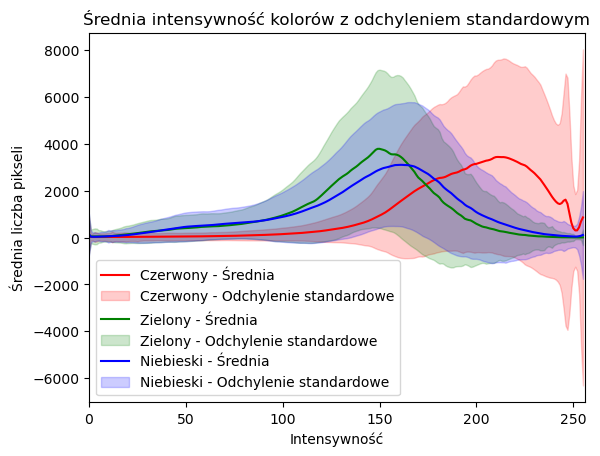

In [19]:
#Badanie intensywności kolorów RGB
# Listy do przechowywania histogramów
r_histograms = []
g_histograms = []
b_histograms = []

for filename in os.listdir(image_directory):
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join(image_directory, filename)).convert('RGB')

        # Rozdzielenie na kanały RGB
        r, g, b = img.split()

        # Konwersja kanałów do tablic numpy
        r = np.array(r)
        g = np.array(g)
        b = np.array(b)

        # Obliczenie histogramu dla każdego kanału i dodanie do listy
        r_histograms.append(np.histogram(r, bins=256, range=(0, 256))[0])
        g_histograms.append(np.histogram(g, bins=256, range=(0, 256))[0])
        b_histograms.append(np.histogram(b, bins=256, range=(0, 256))[0])

# Konwersja list histogramów na tablice numpy
r_histograms = np.array(r_histograms)
g_histograms = np.array(g_histograms)
b_histograms = np.array(b_histograms)

# Obliczenie średniego histogramu i odchylenia standardowego
mean_r_histogram = np.mean(r_histograms, axis=0)
mean_g_histogram = np.mean(g_histograms, axis=0)
mean_b_histogram = np.mean(b_histograms, axis=0)

std_r_histogram = np.std(r_histograms, axis=0)
std_g_histogram = np.std(g_histograms, axis=0)
std_b_histogram = np.std(b_histograms, axis=0)

# Kolory dla wykresu
colors = ('r', 'g', 'b')

plt.figure()
plt.title("Średnia intensywność kolorów z odchyleniem standardowym")
plt.xlabel("Intensywność")
plt.ylabel("Średnia liczba pikseli")

# Rysowanie średnich histogramów z odchyleniem standardowym
plt.plot(mean_r_histogram, color='r', label='Czerwony - Średnia')
plt.fill_between(range(256), mean_r_histogram - std_r_histogram, mean_r_histogram + std_r_histogram, color='r', alpha=0.2, label='Czerwony - Odchylenie standardowe')

plt.plot(mean_g_histogram, color='g', label='Zielony - Średnia')
plt.fill_between(range(256), mean_g_histogram - std_g_histogram, mean_g_histogram + std_g_histogram, color='g', alpha=0.2, label='Zielony - Odchylenie standardowe')

plt.plot(mean_b_histogram, color='b', label='Niebieski - Średnia')
plt.fill_between(range(256), mean_b_histogram - std_b_histogram, mean_b_histogram + std_b_histogram, color='b', alpha=0.2, label='Niebieski - Odchylenie standardowe')

plt.legend()
plt.xlim([0, 256])
plt.show()


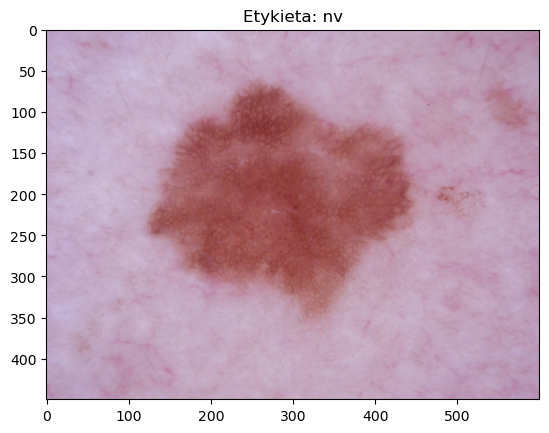

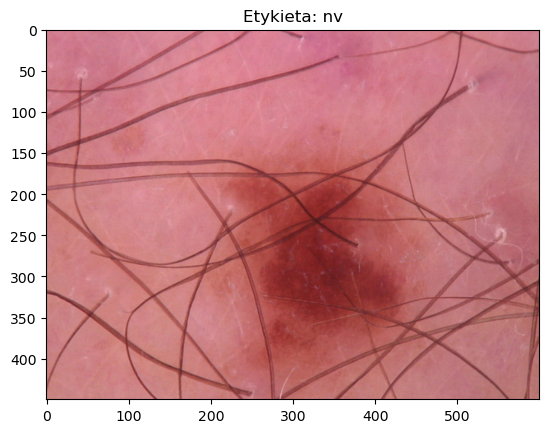

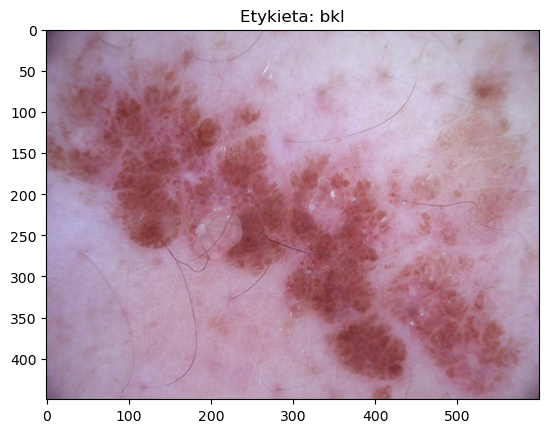

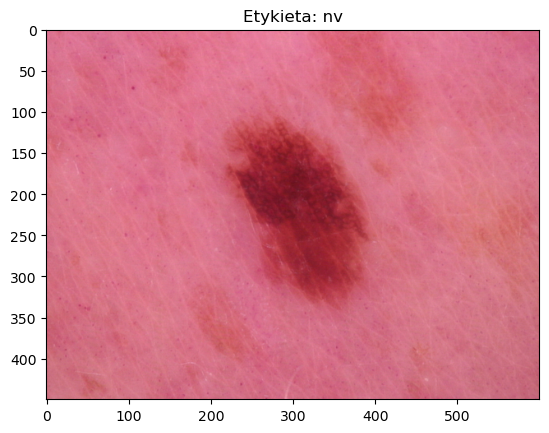

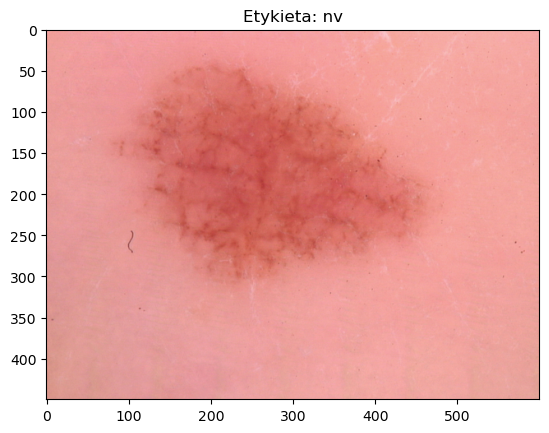

In [20]:
# Wyświetlenie losowych obrazów z etykietami
sample_images = df.sample(5)
for index, row in sample_images.iterrows():
    img = Image.open(os.path.join(image_directory, row['image_id'] + '.jpg'))
    plt.imshow(img)
    plt.title(f"Etykieta: {row['dx']}")
    plt.show()


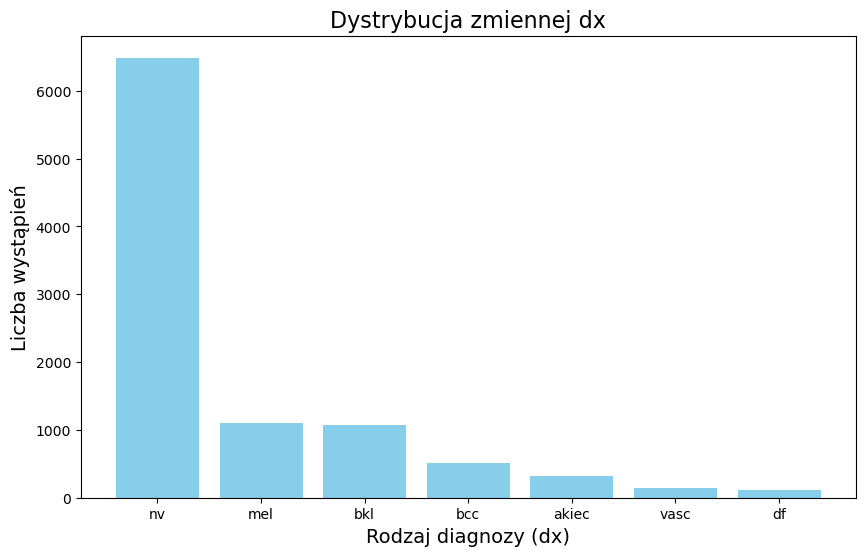

In [21]:
# Obliczanie liczby wystąpień dla każdej kategorii w zmiennej 'dx'
dx_counts = df['dx'].value_counts()

# Tworzenie wykresu słupkowego
plt.figure(figsize=(10, 6))
plt.bar(dx_counts.index, dx_counts.values, color='skyblue')

# Dodanie etykiet i tytułu
plt.title('Dystrybucja zmiennej dx', fontsize=16)
plt.xlabel('Rodzaj diagnozy (dx)', fontsize=14)
plt.ylabel('Liczba wystąpień', fontsize=14)

# Wyświetlenie wykresu
plt.show()

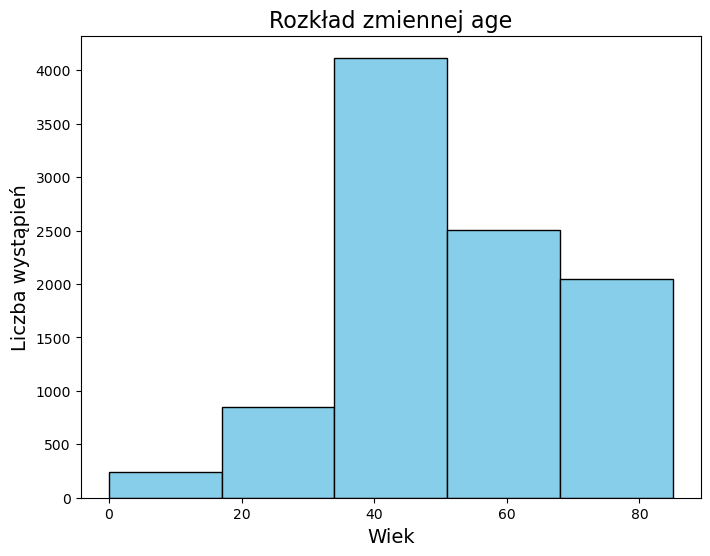

In [22]:
age_df = df['age']

# Tworzenie histogramu
plt.figure(figsize=(8, 6))
plt.hist(age_df, bins=5, color='skyblue', edgecolor='black')

# Dodanie etykiet i tytułu
plt.title('Rozkład zmiennej age', fontsize=16)
plt.xlabel('Wiek', fontsize=14)
plt.ylabel('Liczba wystąpień', fontsize=14)

# Wyświetlenie wykresu
plt.show()


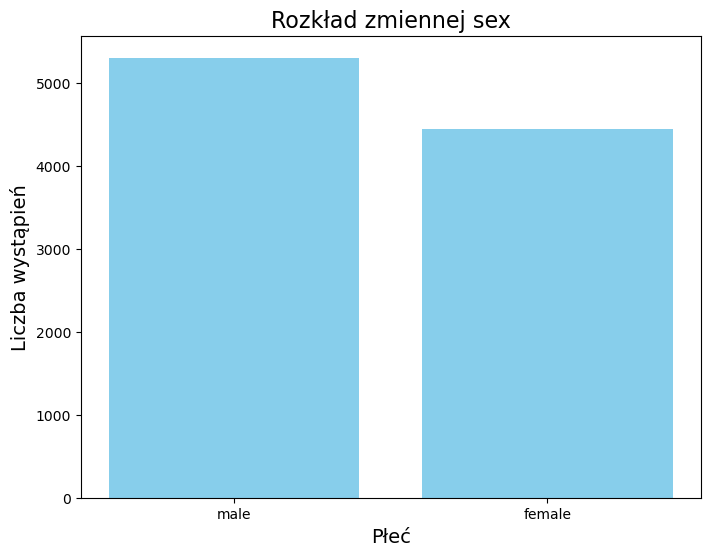

In [23]:
# Obliczanie liczby wystąpień dla każdej kategorii w zmiennej 'sex'
sex_counts = df['sex'].value_counts()

# Tworzenie wykresu słupkowego
plt.figure(figsize=(8, 6))
plt.bar(sex_counts.index, sex_counts.values, color='skyblue')

# Dodanie etykiet i tytułu
plt.title('Rozkład zmiennej sex', fontsize=16)
plt.xlabel('Płeć', fontsize=14)
plt.ylabel('Liczba wystąpień', fontsize=14)

# Wyświetlenie wykresu
plt.show()

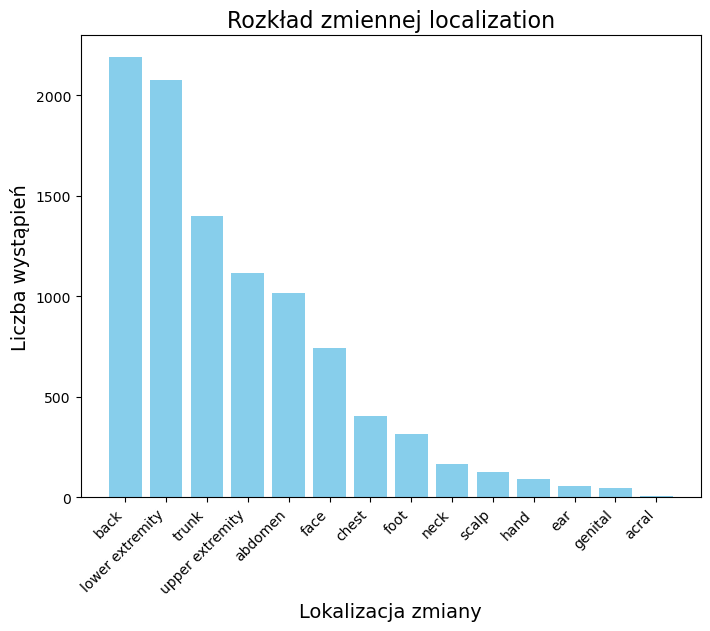

In [24]:
# Obliczanie liczby wystąpień dla każdej kategorii w zmiennej 'localization'
loc_counts = df['localization'].value_counts()

# Tworzenie wykresu słupkowego
plt.figure(figsize=(8, 6))
plt.bar(loc_counts.index, loc_counts.values, color='skyblue')

# Dodanie etykiet i tytułu
plt.title('Rozkład zmiennej localization', fontsize=16)
plt.xlabel('Lokalizacja zmiany', fontsize=14)
plt.ylabel('Liczba wystąpień', fontsize=14)

# Przekręcenie etykiet na osi X o 45 stopni
plt.xticks(rotation=45, ha='right')

# Wyświetlenie wykresu
plt.show()

In [25]:
print(df[df['localization'] == 'ear'])


        lesion_id      image_id     dx   age     sex localization
4     HAM_0001466  ISIC_0031633    bkl  75.0    male          ear
5     HAM_0001466  ISIC_0027850    bkl  75.0    male          ear
73    HAM_0000907  ISIC_0025140    bkl  75.0    male          ear
74    HAM_0000907  ISIC_0025554    bkl  75.0    male          ear
529   HAM_0002058  ISIC_0024893    bkl  65.0  female          ear
566   HAM_0001944  ISIC_0029810    bkl  55.0  female          ear
1233  HAM_0001150  ISIC_0030486    mel  80.0    male          ear
1264  HAM_0002720  ISIC_0025277    mel  75.0    male          ear
1305  HAM_0006739  ISIC_0028901    mel  35.0  female          ear
1306  HAM_0006739  ISIC_0032098    mel  35.0  female          ear
1336  HAM_0001284  ISIC_0024972    mel  75.0  female          ear
1337  HAM_0001284  ISIC_0031779    mel  75.0  female          ear
1359  HAM_0005084  ISIC_0027261    mel  75.0    male          ear
1360  HAM_0005084  ISIC_0028505    mel  75.0    male          ear
1365  HAM_

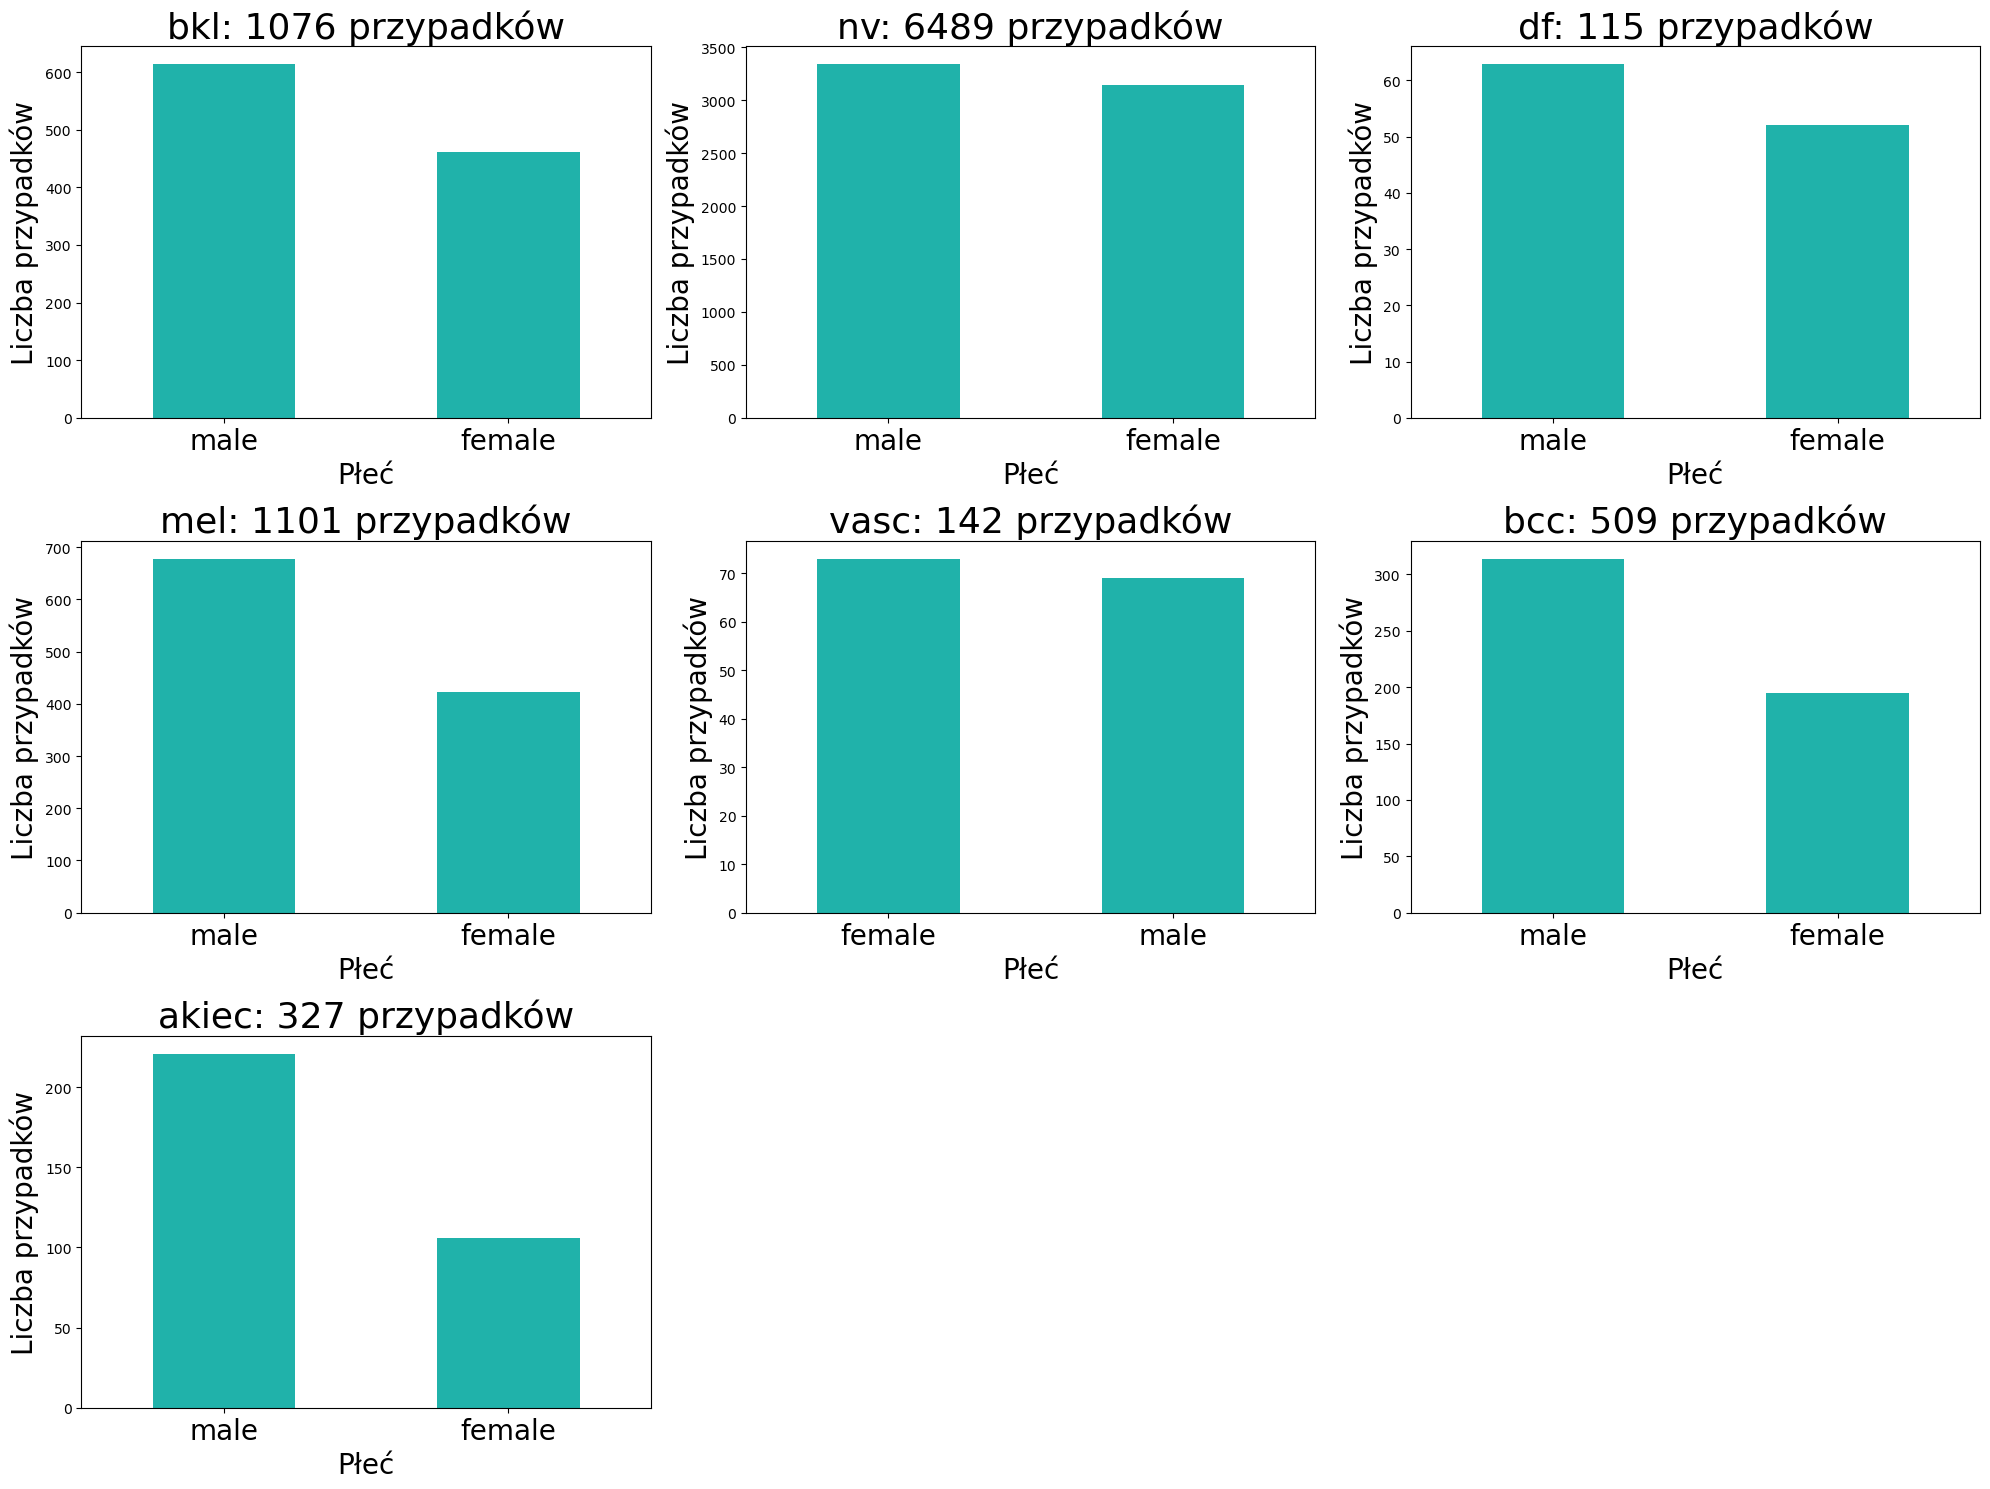

In [26]:
unique_dx = df['dx'].unique()

# Ustawienie rozmiaru wykresu
plt.figure(figsize=(20, 15))

# Iteracja przez każdą diagnozę i tworzenie wykresu
for i, dx_value in enumerate(unique_dx):
    plt.subplot(3, 3, i + 1)  # Ustawienie 3x3 siatki wykresów 

    # Filtracja danych dla aktualnej diagnozy
    data = df[df['dx'] == dx_value]

    # Tworzenie wykresu słupkowego dla każdej płci
    data['sex'].value_counts().plot(kind='bar', color='lightseagreen')

    # Ustawienia tytułu i etykiet
    plt.title(f"{dx_value}: {df['dx'].value_counts()[dx_value]} przypadków", fontsize = 26)
    plt.xlabel('Płeć', fontsize = 20)
    plt.ylabel('Liczba przypadków', fontsize = 20)
    plt.xticks(rotation=0, fontsize = 20)

plt.tight_layout()
plt.show()


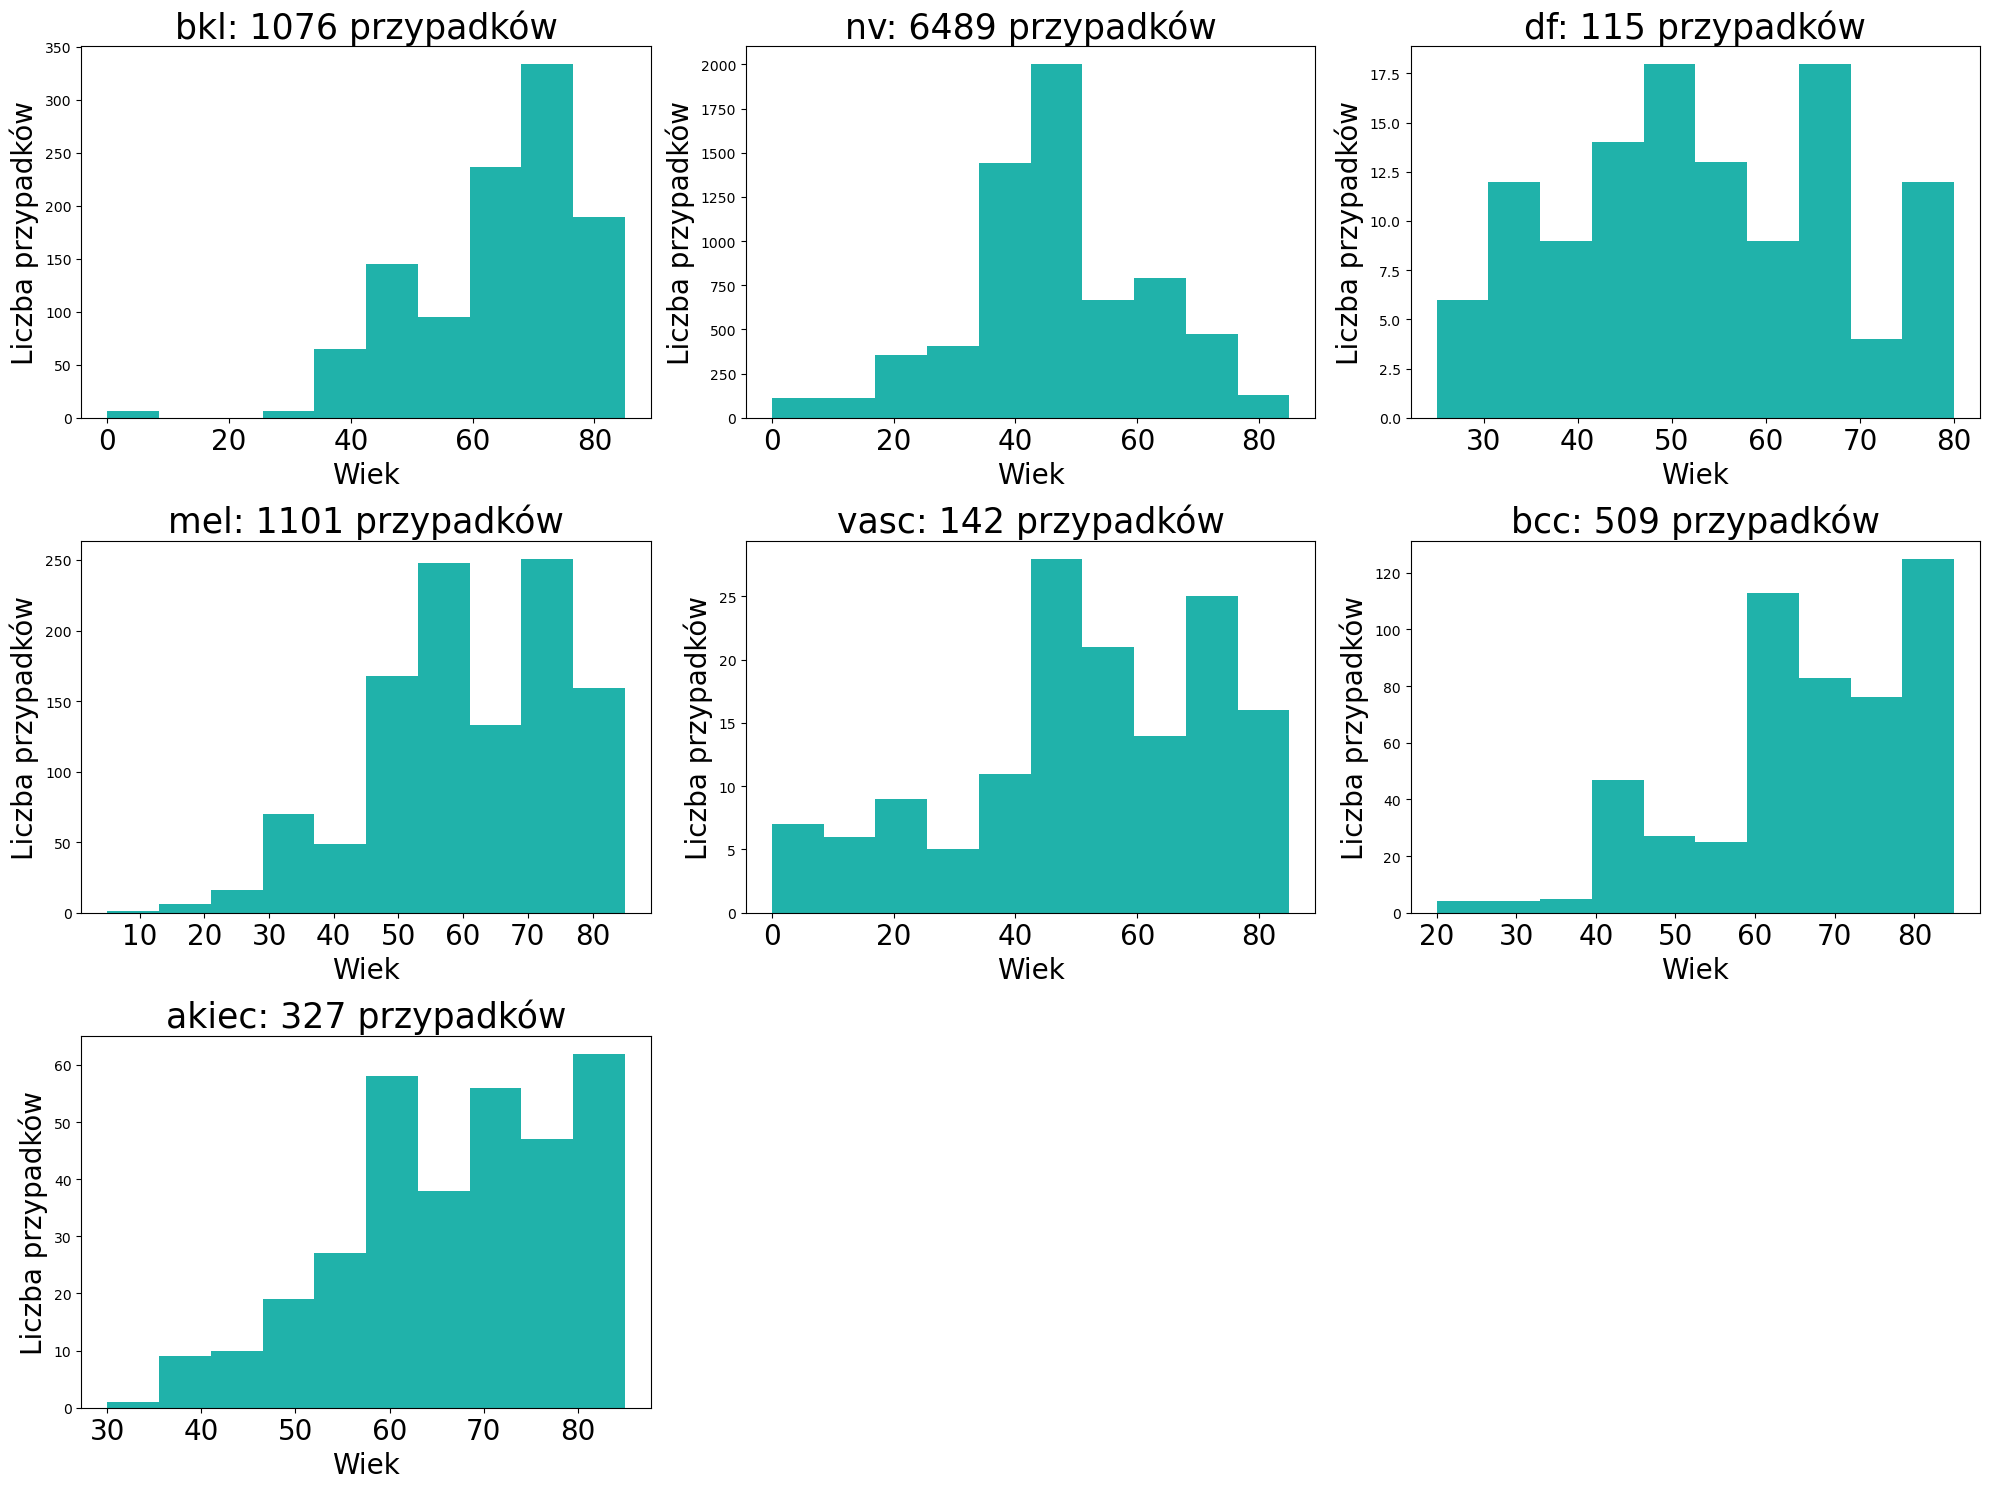

In [27]:
# Ustawienie rozmiaru wykresu
plt.figure(figsize=(20, 15))

# Iteracja przez każdą diagnozę i tworzenie wykresu
for i, dx_value in enumerate(unique_dx):
    plt.subplot(3, 3, i + 1)  # Ustawienie 3x3 siatki wykresów 

    # Filtracja danych dla aktualnej diagnozy
    data = df[df['dx'] == dx_value]

    # Tworzenie wykresu słupkowego dla każdej płci
    data['age'].plot(kind='hist', bins = 10, color='lightseagreen')

    # Ustawienia tytułu i etykiet
    plt.title(f"{dx_value}: {df['dx'].value_counts()[dx_value]} przypadków", fontsize = 25)
    plt.xlabel('Wiek', fontsize = 20)
    plt.ylabel('Liczba przypadków', fontsize = 20)
    plt.xticks(rotation=0, fontsize = 20)

plt.tight_layout()
plt.show()


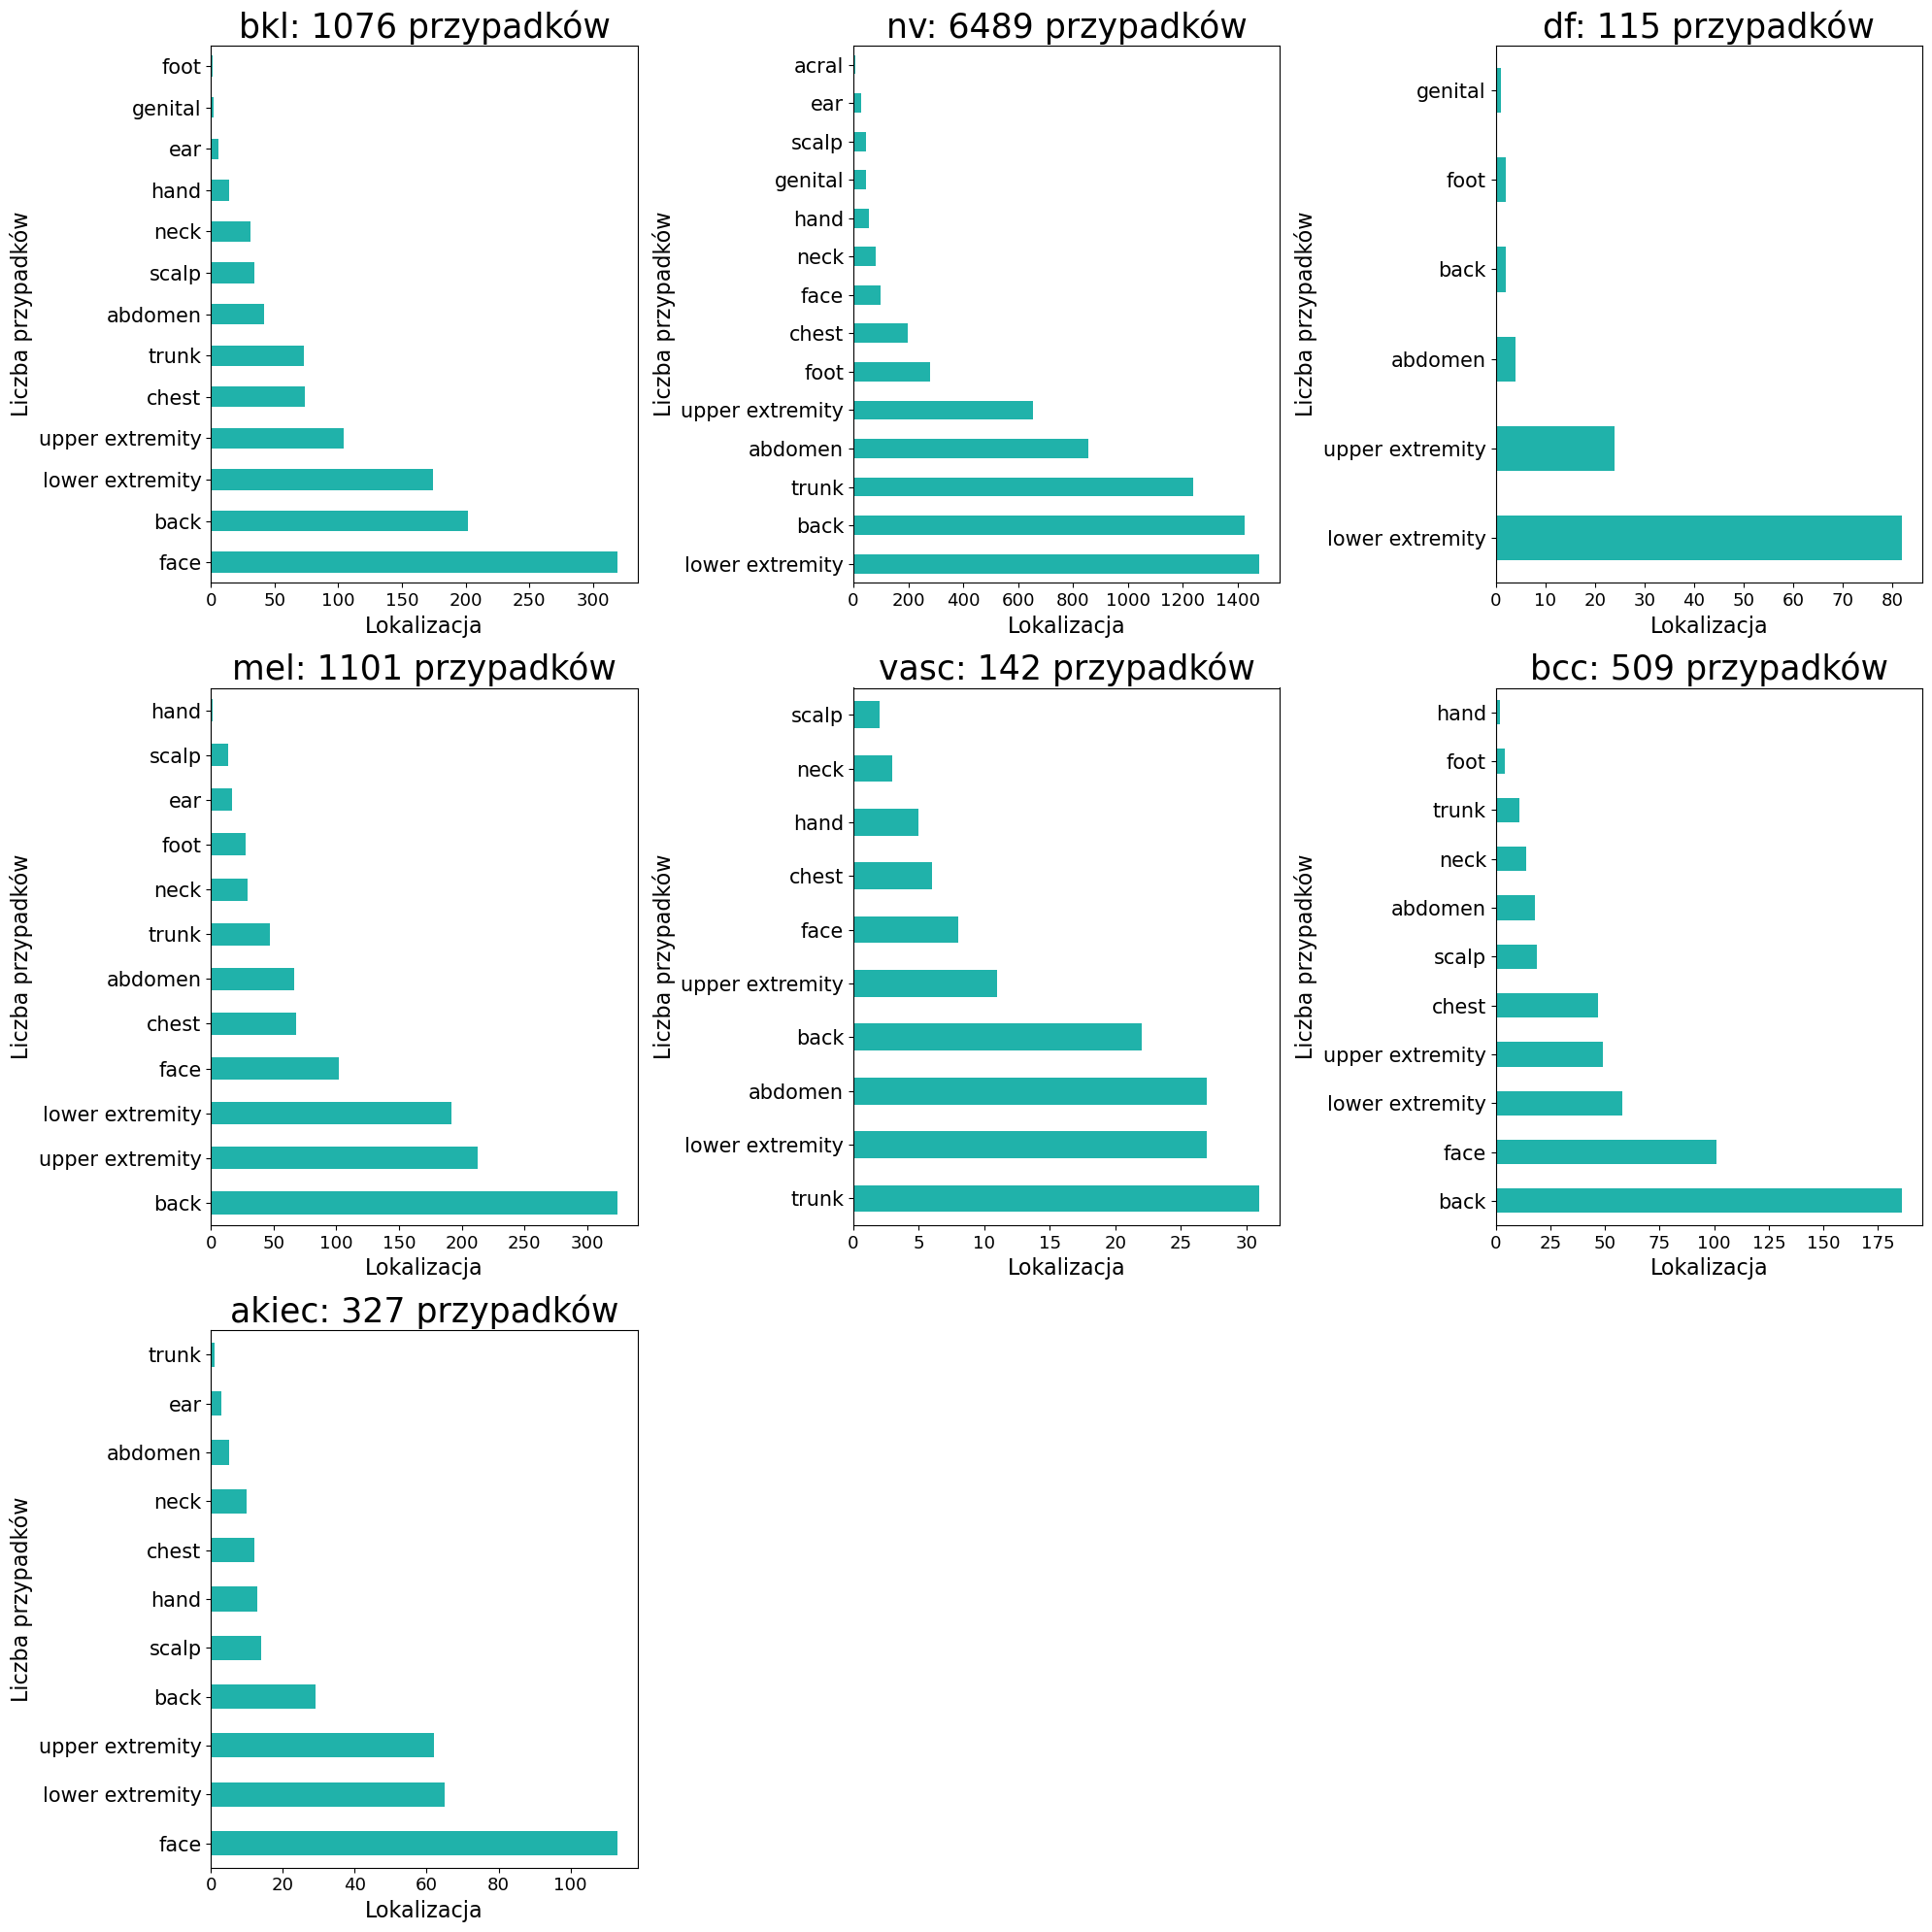

In [28]:
# Ustawienie rozmiaru wykresu
plt.figure(figsize=(20, 20))

# Iteracja przez każdą diagnozę i tworzenie wykresu
for i, dx_value in enumerate(unique_dx):
    plt.subplot(3, 3, i + 1)  # Ustawienie 3x3 siatki wykresów

    # Filtracja danych dla aktualnej diagnozy
    data = df[df['dx'] == dx_value]

    # Tworzenie wykresu słupkowego dla każdej płci
    data['localization'].value_counts().plot(kind='barh', color='lightseagreen')

    # Ustawienia tytułu i etykiet
    plt.title(f"{dx_value}: {df['dx'].value_counts()[dx_value]} przypadków", fontsize = 25)
    plt.xlabel('Lokalizacja', fontsize = 16)
    plt.ylabel('Liczba przypadków', fontsize = 16)
    plt.xticks(rotation=0, fontsize = 13)
    plt.yticks(rotation=0, fontsize = 15)

plt.tight_layout()
plt.show()


In [29]:
# Dodanie kolumny z obrazami
dx_dict = {
    'nv': 'Znamię melanocytowe',
    'mel': 'Czerniak',
    'bkl': 'Łagodne zmiany przypominąjace keratoze ',
    'bcc': 'Rak podstawnokomórkowy',
    'akiec': 'Rogowacenie słoneczne i rak śródnabłonkowy, choroba Bowena',
    'vasc': 'Zmiany naczyniowe',
    'df': 'Włókniak twardy'
}

# Tworzenie słownika mapującego identyfikatory obrazów na pełne ścieżki
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(image_directory, '*.jpg'))}

In [30]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['dx_fullname'] = df['dx'].map(dx_dict.get)
df['dx_fullname_idx'] = pd.Categorical(df['dx_fullname']).codes

In [31]:
df.head()

lesion_id      image_id   dx   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl  75.0  male          ear   

                                                path  \
0  D:/magisterka_new/CNN_HAM10000/data/HAM10000_i...   
1  D:/magisterka_new/CNN_HAM10000/data/HAM10000_i...   
2  D:/magisterka_new/CNN_HAM10000/data/HAM10000_i...   
3  D:/magisterka_new/CNN_HAM10000/data/HAM10000_i...   
4  D:/magisterka_new/CNN_HAM10000/data/HAM10000_i...   

                               dx_fullname  dx_fullname_idx  
0  Łagodne zmiany przypominąjace keratoze                 6  
1  Łagodne zmiany przypominąjace keratoze                 6  
2  Łagodne zmiany przypominąjace keratoze                 6  
3  Łagodne zmiany przypominąjace keratoze                 6  
4  Łagodne zmiany przypominąjace keratoze                 6

In [32]:
df.dtypes

lesion_id           object
image_id            object
dx                  object
age                float64
sex                 object
localization        object
path                object
dx_fullname         object
dx_fullname_idx       int8
dtype: object

In [33]:
# Przetwarzanie obrazów (zmiana rozmiaru do 128x128)
image_size = (128, 128)
def load_image(image_path):
    img = load_img(image_path, target_size=image_size)
    return img_to_array(img)

In [34]:
# Ładowanie i przetwarzanie obrazów na podstawie ścieżek
X_images = np.array([load_image(os.path.join(image_directory, img_id + ".jpg")) for img_id in df['image_id']])

# Normalizacja obrazów
X_images = X_images / 255.0

In [35]:
# Przetwarzanie metadanych (one-hot encoding dla płci i lokalizacji)
df_sex_encoded = pd.get_dummies(df['sex'], prefix='sex')
df_location_encoded = pd.get_dummies(df['localization'], prefix='location')

In [36]:
# Łączenie metadanych (wiek, zakodowana płeć i lokalizacja)
metadata = np.concatenate([df[['age']].values, df_sex_encoded.values, df_location_encoded.values], axis=1)

In [37]:
# Zakodowanie etykiet jako one-hot
y = to_categorical(df['dx_fullname_idx'])

In [48]:
# Funkcja do stworzenia modelu
def create_model(metadata_input_dim):
    # Wejście dla obrazów
    image_input = Input(shape=(128, 128, 3))  # Zdefiniowanie wejścia dla obrazów
    resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

    # Spłaszczenie wyjścia z ResNet50
    x_image = Flatten()(resnet.output)

    # Wejście dla metadanych
    metadata_input = Input(shape=(metadata_input_dim,))
    x_metadata = Dense(64, activation='relu')(metadata_input)

    # Połączenie wyników z ResNet50 i metadanych
    x_combined = Concatenate()([x_image, x_metadata])

    # Dodanie Dense i Dropout
    x_combined = Dense(256, activation='relu')(x_combined)
    x_combined = Dropout(0.5)(x_combined)

    # Warstwa wyjściowa (7 klas zmian skórnych)
    output = Dense(7, activation='softmax')(x_combined)

    # Zbudowanie całego modelu
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [52]:
# Podział zbioru na treningowy i testowy (np. 80% na trening, 20% na test)
X_train_img, X_test_img, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_images, metadata, y, test_size=0.2, random_state=123, stratify=np.argmax(y, axis=1)
)

In [53]:
# Implementacja kroswalidacji 
n_splits = 5  # Liczba foldów w kroswalidacji
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

fold_no = 1
accuracies = []

In [54]:
for train_index, val_index in skf.split(X_train_img, np.argmax(y_train, axis=1)):
    print(f'\nRozpoczęcie treningu dla jednego z foldów...')

    # Podział na dane treningowe i walidacyjne w bieżącym foldzie
    X_train_img_cv, X_val_img_cv = X_train_img[train_index], X_train_img[val_index]
    X_train_meta_cv, X_val_meta_cv = X_train_meta[train_index], X_train_meta[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    # Obliczenie wag klas dla aktualnego folda
    y_train_labels_cv = np.argmax(y_train_cv, axis=1)
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_labels_cv),
        y=y_train_labels_cv
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Stworzenie nowej instancji modelu
    model_cv = create_model(X_train_meta.shape[1])

    # Trenowanie modelu na zbiorze treningowym i walidacja
    model_cv.fit(
        [X_train_img_cv, X_train_meta_cv], y_train_cv,
        validation_data=([X_val_img_cv, X_val_meta_cv], y_val_cv),
        epochs=20,
        batch_size=16,
        class_weight=class_weights_dict
    )

    # Ewaluacja na zbiorze walidacyjnym
    val_loss, val_accuracy = model_cv.evaluate([X_val_img_cv, X_val_meta_cv], y_val_cv)
    print(f'Walidacyjna dokładność: {val_accuracy}')
    accuracies.append(val_accuracy)


Rozpoczęcie treningu dla jednego z foldów...
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 406s 920ms/step - accuracy: 0.5205 - loss: 2.6799 - val_accuracy: 0.6652 - val_loss: 35.0002
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 353s 904ms/step - accuracy: 0.6287 - loss: 0.9401 - val_accuracy: 0.6652 - val_loss: 6.2149
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 357s 912ms/step - accuracy: 0.6861 - loss: 0.8539 - val_accuracy: 0.7234 - val_loss: 0.7525
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 352s 901ms/step - accuracy: 0.7784 - loss: 0.3896 - val_accuracy: 0.7657 - val_loss: 0.6599
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 351s 898ms/step - accuracy: 0.8293 - loss: 0.2836 - val_accuracy: 0.7042 - val_loss: 1.6666
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 351s 897ms/step - accuracy: 0.6521 - loss: 1.0205 - val_accuracy: 0.6972 - val_loss: 0.8740
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 360s 920ms/step - accuracy: 0.7056 - loss: 0.6730 - val_accuracy: 0.6633 - val_loss: 1.0777
Epoch 8/20
391/391 ━━━━━━━━━━

In [55]:
# Wyniki kroswalidacji
mean_accuracy = np.mean(accuracies)
print(f'Średnia dokładność po kroswalidacji: {mean_accuracy:.4f}')

Średnia dokładność po kroswalidacji: 0.7597


In [56]:
# --- FINALNY MODEL (TRENING NA CAŁYM ZBIORZE TRENINGOWYM) ---

# Trening finalnego modelu na pełnym zbiorze treningowym (bez walidacji)
final_model = create_model(X_train_meta.shape[1])
final_model.fit([X_train_img, X_train_meta], y_train, epochs=20, batch_size=16)

Epoch 1/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 459s 857ms/step - accuracy: 0.6811 - loss: 1.1896
Epoch 2/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 418s 857ms/step - accuracy: 0.8110 - loss: 0.5409
Epoch 3/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 419s 859ms/step - accuracy: 0.8869 - loss: 0.3218
Epoch 4/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 420s 860ms/step - accuracy: 0.9167 - loss: 0.2349
Epoch 5/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 420s 861ms/step - accuracy: 0.9218 - loss: 0.2719
Epoch 6/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 422s 864ms/step - accuracy: 0.8534 - loss: 0.4318
Epoch 7/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 420s 862ms/step - accuracy: 0.9281 - loss: 0.2577
Epoch 8/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 424s 868ms/step - accuracy: 0.9644 - loss: 0.1279
Epoch 9/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 421s 863ms/step - accuracy: 0.9729 - loss: 0.0883
Epoch 10/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 420s 860ms/step - accuracy: 0.9777 - loss: 0.0663
Epoch 11/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 421s 862ms/step - accuracy: 0.9788 - loss: 0.0641
Epoch 12

In [58]:
# --- OCENA NA ZBIORZE TESTOWYM ---
# Ewaluacja finalnego modelu na osobnym zbiorze testowym
test_loss, test_accuracy = final_model.evaluate([X_test_img, X_test_meta], y_test)
print(f'Dokładność na zbiorze testowym: {test_accuracy:.4f}')

61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.8331 - loss: 0.9911
Dokładność na zbiorze testowym: 0.8171
